In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import json
from glob import glob
import requests
from datetime import datetime 
import os

### Settings

In [ ]:
# Elfi QA  
# unit_id = 7536f0b1-2510-4f94-a9b6-38390da72cd8 

#token_path = ".secrets/qa_autopi_token.txt"
req_url = "https://api.cloud01.qa.autopi.io/logbook/raw/"
start = "2025-06-23T07:05:00.000Z"
end   = "2025-06-23T07:10:00.000Z"
save_path= "/tmp/"

std_loggers = ["std.accelerometer_axis_x","std.total_odometer","std.battery_level","std.accelerometer_axis_z","std.trip_odometer","std.fuel_rate_gps","std.accelerometer_axis_y","std.trip_odometer","std.battery_current","std.speed","std.gsm_signal","std.fuel_used_gps", "opt.iccid2", "std.ignition"]

track_loggers = ["track.pos.nsat","track.pos.cog","track.pos.alt","track.pos.pr","track.pos.sog","track.pos.loc"]

obd2_loggers = ["obd.time_since_codes_cleared","obd.absolute_load","obd.time_run_with_mil_on","obd.commanded_egr","obd.fuel_level","obd.barometic_pressure","obd.absolute_fuel_rail_pressure","obd.bat.voltage","obd.short_fuel_trim","obd.number_of_dtc","obd.fuel_injection_timing","obd.maf","obd.timing_advance","obd.intake_temp","obd.fuel_pressure","obd.oil_temp","obd.coolant_temp","obd.egr_error","obd.control_module_voltage","obd.maf","obd.intake_map","obd.ambient_air_temp","obd.bat.level","obd.throttle_pos","obd.fuel_rail_pressure_vac","obd.fuel_rail_pressure_direct","obd.obd_oem_total_mileage","obd.hybrid_battery_pack_life","obd.speed","obd.distance_since_codes_clear","obd.run_time","obd.distance_w_mil","obd.rpm","obd.fuel_type"]


obd_oem = ["obd.oem_hv_battery_max_cell_voltage", "obd.oem_battery_charge_level","obd.oem_battery_temperature","obd.oem_hv_battery_measured_energy", "obd.oem_hv_battery_max_cell_temperature","obd.oem_hv_battery_min_cell_voltage", "obd.oem_hv_battery_min_cell_temperature", "obd.oem_remaining_distance", "obd.oem_hv_battery_lifetime_charge_power", "obd.oem_hv_battery_max_energy", "obd.oem_hv_battery_current", "obd.oem_hv_battery_lifetime_power_use", "obd.oem_battery_charge_state","obd.oem_battery_state_of_health"]

loggers = std_loggers + track_loggers + obd2_loggers + obd_oem

print(f"STD Loggers: {len(std_loggers)}")
print(f"Track Loggers: {len(track_loggers)}")
print(f"OBD Loggers: {len(obd2_loggers)}")
print(f"OBD OEM Loggers: {len(obd_oem)}")

"""
Example to make request to logbook/storage/read

https://api.cloud01.qa.autopi.io/logbook/storage/read/
field=std.gsm_signal
field_type=int
aggregation=avg
from_utc=2025-06-22T22:00:00.063Z
end_utc=2025-06-23T09:13:55.315Z
interval=1m
"""

STD Loggers: 14
Track Loggers: 6
OBD Loggers: 34
OBD OEM Loggers: 14


'\nExample to make request to logbook/storage/read\n\nhttps://api.cloud01.qa.autopi.io/logbook/storage/read/\nfield=std.gsm_signal\nfield_type=int\naggregation=avg\nfrom_utc=2025-06-22T22:00:00.063Z\nend_utc=2025-06-23T09:13:55.315Z\ninterval=1m\n'

In [10]:
expected_loggers = ["obd.oem_hv_battery_lifetime_charge_power","obd.ambient_air_temp","std.battery_voltage","std.battery_level","obd.oem_battery_charge_level","std.gsm_signal","obd.oem_hv_battery_current","obd.oem_battery_temperature","obd.oem_hv_battery_current","obd.oem_hv_battery_max_cell_temperature","obd.oem_hv_battery_min_cell_temperature","obd.oem_hv_battery_max_cell_voltage","obd.oem_hv_battery_min_cell_voltage","obd.bat.voltage","std.total_odometer","obd.oem_battery_charge_state","std.ignition","obd.speed","obd.oem_hv_battery_lifetime_power_use","obd.oem_hv_battery_max_energy"]

In [12]:
# "obd.oem_hv_battery_lifetime_charge_power",
# "obd.ambient_air_temp",
# "std.battery_voltage",
# "std.battery_level",
# "obd.oem_battery_charge_level",
# "std.gsm_signal",
# "obd.oem_hv_battery_current",
# "obd.oem_battery_temperature",
# "obd.oem_hv_battery_current",
# "obd.oem_hv_battery_max_cell_temperature",
# "obd.oem_hv_battery_min_cell_temperature",
# "obd.oem_hv_battery_max_cell_voltage",
# "obd.oem_hv_battery_min_cell_voltage",
# "obd.bat.voltage","std.total_odometer",
# "obd.oem_battery_charge_state",
# "std.ignition","obd.speed",
# "obd.oem_hv_battery_lifetime_power_use",
# "obd.oem_hv_battery_max_energy"

In [11]:
len(expected_loggers)

20

### API request and data transformations

In [3]:
def save_response(page_num, response, logger: str, path: str):
    os.makedirs(path, exist_ok=True)  # Ensure the directory exists
    file_name = f"{logger.replace('.', '_')}_{page_num}.json"
    file_path = os.path.join(path, file_name)  # Safer path joining
    with open(file_path, 'w') as json_response:
        json_response.write(response.text)
    return file_path

In [18]:
# Set the environment variable
os.environ["MY_TOKEN"] = token#content

headers_list = {
 "Accept": "*/*",
 "Content-Type": "application/json",
 "Authorization": f"APIToken {os.environ.get('MY_TOKEN')}" 
}

json_files = []

for logger in loggers: 
    one_day_params = {"device_id":"7536f0b1-2510-4f94-a9b6-38390da72cd8",
            "page_num":0,
            "page_size":1000, 
            "data_type": logger,
            "start_utc": start,
            "end_utc": end,
            "upload_time": False }

    response = requests.request("GET", req_url, params=one_day_params, headers=headers_list)
    new_file = save_response(0, response, logger,save_path )
    
    json_files.append(new_file)
    total_records = response.json()['count']
    print(f"Found {total_records} data points from {start} to {end} for {logger} logger")
    total_pages = round(total_records / 1000) 

    page_num = 0
    while page_num < total_pages: # request next pages
        page_num += 1
        one_day_params["page_num"] = page_num
        response = requests.request("GET", req_url, params=one_day_params, headers=headers_list)
        new_file = save_response(page_num, response, logger, save_path)
        json_files.append(new_file)

Found 0 data points from 2025-06-23T07:05:00.000Z to 2025-06-23T07:10:00.000Z for std.accelerometer_axis_x logger
Found 274 data points from 2025-06-23T07:05:00.000Z to 2025-06-23T07:10:00.000Z for std.total_odometer logger
Found 274 data points from 2025-06-23T07:05:00.000Z to 2025-06-23T07:10:00.000Z for std.battery_level logger
Found 0 data points from 2025-06-23T07:05:00.000Z to 2025-06-23T07:10:00.000Z for std.accelerometer_axis_z logger
Found 0 data points from 2025-06-23T07:05:00.000Z to 2025-06-23T07:10:00.000Z for std.trip_odometer logger
Found 0 data points from 2025-06-23T07:05:00.000Z to 2025-06-23T07:10:00.000Z for std.fuel_rate_gps logger
Found 0 data points from 2025-06-23T07:05:00.000Z to 2025-06-23T07:10:00.000Z for std.accelerometer_axis_y logger
Found 0 data points from 2025-06-23T07:05:00.000Z to 2025-06-23T07:10:00.000Z for std.trip_odometer logger
Found 274 data points from 2025-06-23T07:05:00.000Z to 2025-06-23T07:10:00.000Z for std.battery_current logger
Found 0

### Convert to CSV

In [ ]:
def load_json_results(file_path):
    with open(file_path, 'r') as f:
        return json.load(f)["results"]

# Create full file patterns
file_map = {
    "obd_rpm": sorted(glob(os.path.join(save_path, "obd_rpm_*.json"))),
    "obd_speed": sorted(glob(os.path.join(save_path, "obd_speed_*.json"))),
    "obd_engine_load": sorted(glob(os.path.join(save_path, "obd_engine_load_*.json"))),
}

print("RPM files found:", file_map["obd_rpm"])

# Build a dictionary indexed by ts
data_by_ts = {}

for key, files in file_map.items():
    for file in files:
        for entry in load_json_results(file):
            ts = entry["ts"]
            rec = entry["rec"]
            val = entry["data"]["value"]
            if ts not in data_by_ts:
                data_by_ts[ts] = {
                    "ts_recorded": ts,
                    "ts_uploaded": rec,
                    "obd_rpm": None,
                    "obd_speed": None,
                    "obd_engine_load": None
                }
            if rec > data_by_ts[ts]["ts_uploaded"]:
                data_by_ts[ts]["ts_uploaded"] = rec
            data_by_ts[ts][key] = val

# Convert to DataFrame
df = pd.DataFrame(data_by_ts.values())
df.sort_values("ts_recorded", inplace=True)

# Save CSV to same directory
csv_output = os.path.join(save_path, "mini_obd_data.csv")
df.to_csv(csv_output, index=False)
print(f"CSV saved to {csv_output}")

RPM files found: ['~/Downloads/obd_rpm_0.json', '~/Downloads/obd_rpm_1.json', '~/Downloads/obd_rpm_2.json', '~/Downloads/obd_rpm_3.json', '~/Downloads/obd_rpm_4.json']
CSV saved to ~/Downloads/mini_obd_data.csv


### EDA

In [13]:
df = pd.read_csv(f"{save_path}/mini_obd_data.csv")

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3550 entries, 0 to 3549
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   ts_recorded      3550 non-null   object
 1   ts_uploaded      3550 non-null   object
 2   obd_rpm          3550 non-null   int64 
 3   obd_speed        3550 non-null   int64 
 4   obd_engine_load  3550 non-null   int64 
dtypes: int64(3), object(2)
memory usage: 138.8+ KB


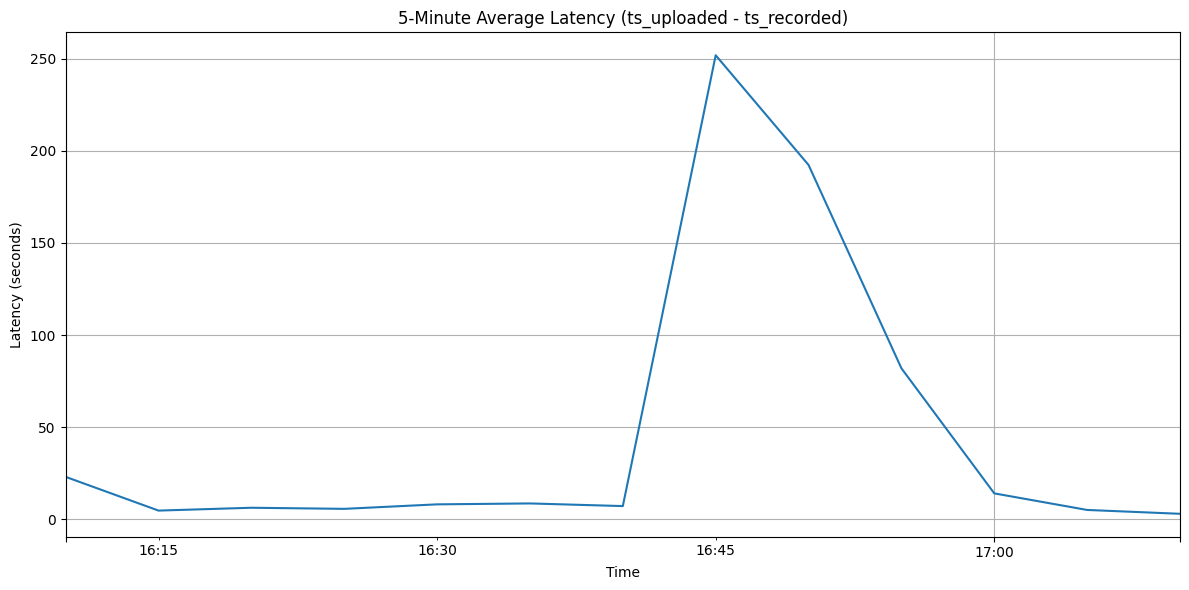

In [16]:
# Convert timestamps to datetime format
df["ts_recorded"] = pd.to_datetime(df["ts_recorded"], utc=True)
df["ts_uploaded"] = pd.to_datetime(df["ts_uploaded"], utc=True)

# Compute latency in seconds
df["latency_sec"] = (df["ts_uploaded"] - df["ts_recorded"]).dt.total_seconds()

# Set ts_recorded as the index for time-based operations
df.set_index("ts_recorded", inplace=True)

# Compute 5-minute average latency
latency_5min_avg = df["latency_sec"].resample("5min").mean()

# Plot the 5-minute average latency
plt.figure(figsize=(12, 6))
latency_5min_avg.plot()
plt.title("5-Minute Average Latency (ts_uploaded - ts_recorded)")
plt.xlabel("Time")
plt.ylabel("Latency (seconds)")
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# # Convert the 'ts' column to datetime
# df['ts'] = pd.to_datetime(df['ts'])

# # Plotting
# plt.figure(figsize=(12, 6))
# plt.plot(df['ts'], df['value'], label="Battery Voltage", color='blue')

# # Set x-axis to display time labels every 15 minutes without the year
# plt.gca().xaxis.set_major_locator(mdates.MinuteLocator(interval=35))
# plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

# # Rotate x labels for clarity
# plt.xlabel('Time')
# plt.xticks(rotation=90)

# # Y-axis and other plot elements
# plt.ylabel('Battery Voltage (V)')
# plt.title('Battery Voltage vs. Time')
# plt.legend()
# plt.grid(True)
# plt.tight_layout()
# plt.show()